# **Initial Steps**

In [58]:
import zipfile
import os
import numpy as np
import time
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2,DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, roc_auc_score, average_precision_score
import krippendorff
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.metrics import classification_report


In [1]:
!pip install krippendorff

In [3]:
def unzip_dataset(zip_path, extract_path="DL_Dataset"):
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Dataset extracted to: {extract_path}")
    return extract_path

dataset_path = unzip_dataset("DL_Assignment1_Dataset.zip")


Dataset extracted to: DL_Dataset


In [4]:
training_times_class = {}
training_times_reg = {}

In [5]:
# Paths Configuration

DATA_DIR = "DL_Dataset/Dataset/Dataset"
IMAGES_DIR = os.path.join(DATA_DIR, "images")
ANNOTATIONS_DIR = os.path.join(DATA_DIR, "annotations")

In [6]:
# Load Images and Annotations (Modular Function)
def load_dataset(images_dir, annotations_dir):
    data = []

    # Collect and sort all image files
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])
    print(f"Found {len(image_files)} images.")

    for img_file in image_files:
        img_id = os.path.splitext(img_file)[0]

        #Load image
        img_path = os.path.join(images_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #from BGR → RGB

        #Load corresponding annotations
        aro = np.load(os.path.join(annotations_dir, f"{img_id}_aro.npy"))
        val = np.load(os.path.join(annotations_dir, f"{img_id}_val.npy"))
        exp = np.load(os.path.join(annotations_dir, f"{img_id}_exp.npy"))

        #Store as dictionary
        data.append({
            'image': img,
            'expression': int(exp),
            'arousal': float(aro),
            'valence': float(val)
        })

    return data

dataset = load_dataset(IMAGES_DIR, ANNOTATIONS_DIR)
print("Example record keys:", dataset[0].keys())


Found 3999 images.
Example record keys: dict_keys(['image', 'expression', 'arousal', 'valence'])


In [7]:
# Preprocessing
def preprocess_dataset(dataset, img_size=(128, 128)):
    X, y_class, y_reg = [], [], []

    for item in dataset:
        # Resize image and normalize pixel values to [0,1]
        img_resized = cv2.resize(item['image'], img_size) / 255.0
        X.append(img_resized)

        # Expression labels for classification
        y_class.append(item['expression'])

        # Valence and arousal values for regression
        y_reg.append([item['valence'], item['arousal']])

    # Convert to numpy arrays for model input
    X = np.array(X, dtype=np.float32)
    y_class = np.array(y_class, dtype=np.int32)
    y_reg = np.array(y_reg, dtype=np.float32)

    print("Images shape:", X.shape)
    print("Expression labels shape:", y_class.shape)
    print("Valence/Arousal shape:", y_reg.shape)

    return X, y_class, y_reg


X, y_class, y_reg = preprocess_dataset(dataset, img_size=(128, 128))


Images shape: (3999, 128, 128, 3)
Expression labels shape: (3999,)
Valence/Arousal shape: (3999, 2)


In [8]:
# Train-Validation-Test Split
X_train, X_temp, y_class_train, y_class_temp, y_reg_train, y_reg_temp = train_test_split(
X, y_class, y_reg, test_size=0.3, random_state=42, stratify=y_class
)


X_val, X_test, y_class_val, y_class_test, y_reg_val, y_reg_test = train_test_split(
X_temp, y_class_temp, y_reg_temp, test_size=0.5, random_state=42, stratify=y_class_temp
)

print("Train set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

Train set: (2799, 128, 128, 3)
Validation set: (600, 128, 128, 3)
Test set: (600, 128, 128, 3)


# **MobileNetV2 model**

In [9]:
# Classification Model

def build_classification_model():
  base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
  base.trainable = False # Freeze conv base layers initially

  x = GlobalAveragePooling2D()(base.output) # Global feature pooling
  x = Dense(256, activation='relu')(x)  # Fully connected layer
  x = Dropout(0.5)(x)            # Dropout for regularization
  output = Dense(8, activation='softmax')(x)    # Output softmax layer

  # Build and compile model
  model = Model(inputs=base.input, outputs=output)
  model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model


classification_model = build_classification_model()
classification_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,587,976 (9.87 MB)

 Trainable params: 329,992 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
# Regression Model

def build_regression_model():
  base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
  base.trainable = False     # Freeze conv base layers initially

  x = GlobalAveragePooling2D()(base.output)  # Global feature pooling
  x = Dense(256, activation='relu')(x)    # Fully connected layer
  x = Dropout(0.5)(x)                   # Dropout for regularization
  output = Dense(2, activation='linear')(x)   # Linear outputs: [valence, arousal]

  model = Model(inputs=base.input, outputs=output)
  model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])
  return model

regression_model = build_regression_model()
regression_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,586,434 (9.87 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# Train Classification Model
start = time.time()

mobilenet_classification_history = classification_model.fit(
X_train, y_class_train,
validation_data=(X_val, y_class_val),
epochs=10,
batch_size=16
)

training_times_class["MobileNet"] = time.time() - start


Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 44s 153ms/step - accuracy: 0.1262 - loss: 2.5215 - val_accuracy: 0.1883 - val_loss: 2.0166
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2087 - loss: 2.0624 - val_accuracy: 0.2367 - val_loss: 1.9718
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2464 - loss: 1.9702 - val_accuracy: 0.2400 - val_loss: 1.9596
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2678 - loss: 1.9120 - val_accuracy: 0.2533 - val_loss: 1.9336
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3208 - loss: 1.8251 - val_accuracy: 0.2733 - val_loss: 1.9147
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3469 - loss: 1.7943 - val_accuracy: 0.2800 - val_loss: 1.8954
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3548 - loss: 1.7228 - val_accuracy: 0.2800 - val_loss: 1.8804
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3750 - loss: 1.6896 - val_ac

In [12]:
# Train Regression Model
start = time.time()

mobilenet_regression_history = regression_model.fit(
X_train, y_reg_train,
validation_data=(X_val, y_reg_val),
epochs=10,
batch_size=16
)

training_times_reg["MobileNet"] = time.time() - start


Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - loss: 0.9060 - mae: 0.7407 - val_loss: 0.2150 - val_mae: 0.3811
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2621 - mae: 0.4151 - val_loss: 0.1913 - val_mae: 0.3635
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2037 - mae: 0.3693 - val_loss: 0.1853 - val_mae: 0.3599
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1877 - mae: 0.3536 - val_loss: 0.1808 - val_mae: 0.3545
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1739 - mae: 0.3447 - val_loss: 0.1779 - val_mae: 0.3497
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1651 - mae: 0.3323 - val_loss: 0.1758 - val_mae: 0.3507
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1573 - mae: 0.3267 - val_loss: 0.1751 - val_mae: 0.3466
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1534 - mae: 0.3218 - val_loss: 0.1725 - val_mae: 0.3460
Epoch 9/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step 

**Evaluation Metrics - MobileNet**

*Classification*

In [14]:
# Accuracy, F1, Cohen's Kappa

# Make predictions
y_class_pred_probs_mobilenet = classification_model.predict(X_test)
y_class_pred_mobilenet = y_class_pred_probs_mobilenet.argmax(axis=1)  # Convert softmax to class labels


# Convert true labels to integers if they're one-hot
if y_class_test.ndim > 1:
    y_class_true = y_class_test.argmax(axis=1)
else:
    y_class_true = y_class_test

# Compute metrics
mobilenet_accuracy = accuracy_score(y_class_true, y_class_pred_mobilenet)
mobilenet_f1 = f1_score(y_class_true, y_class_pred_mobilenet, average='weighted')
mobilenet_kappa = cohen_kappa_score(y_class_true, y_class_pred_mobilenet)

print(f"Accuracy: {mobilenet_accuracy:.4f}")
print(f"F1-Score: {mobilenet_f1:.4f}")
print(f"Cohen's Kappa: {mobilenet_kappa:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 602ms/step
Accuracy: 0.2950
F1-Score: 0.2844
Cohen's Kappa: 0.1943


In [15]:
#Krippendorff’s Alpha

mobilenet_alpha = krippendorff.alpha(reliability_data=[y_class_true, y_class_pred_mobilenet])
print(f"Krippendorff’s Alpha: {mobilenet_alpha:.4f}")

Krippendorff’s Alpha: 0.1045


In [16]:
#AUC-ROC, AUC-PR

# One-hot encode true labels if needed
y_class_true_onehot = to_categorical(y_class_true, num_classes=8)

# AUC (macro average across classes)
mobilenet_auc_roc = roc_auc_score(y_class_true_onehot, y_class_pred_probs_mobilenet, average='macro', multi_class='ovr')
mobilenet_auc_pr = average_precision_score(y_class_true_onehot, y_class_pred_probs_mobilenet, average='macro')

print(f"AUC-ROC: {mobilenet_auc_roc:.4f}")
print(f"AUC-PR: {mobilenet_auc_pr:.4f}")

AUC-ROC: 0.7076
AUC-PR: 0.2845


*Regression*

In [17]:
#RMSE

# valence and arousal values prediction using regression model
y_reg_pred_mobilenet = regression_model.predict(X_test)

# ground truth values
valence_true = y_reg_test[:, 0]
arousal_true = y_reg_test[:, 1]
# predicted values
valence_pred_mobilenet = y_reg_pred_mobilenet[:, 0]
arousal_pred_mobilenet = y_reg_pred_mobilenet[:, 1]

# Compute RMSE for valence and arousal
mobilenet_rmse_valence = np.sqrt(mean_squared_error(valence_true, valence_pred_mobilenet))
mobilenet_rmse_arousal = np.sqrt(mean_squared_error(arousal_true, arousal_pred_mobilenet))

print(f"MobileNetV2 RMSE - Valence: {mobilenet_rmse_valence:.4f}, Arousal: {mobilenet_rmse_arousal:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 371ms/step
MobileNetV2 RMSE - Valence: 0.4435, Arousal: 0.3696


In [18]:
#pearson correlation

#coefficient btw true and predicted values for valence and arousal
mobilenet_corr_valence, _ = pearsonr(valence_true, valence_pred_mobilenet)
mobilenet_corr_arousal, _ = pearsonr(arousal_true, arousal_pred_mobilenet)

print(f"MobileNetV2 Correlation - Valence: {mobilenet_corr_valence:.4f}, Arousal: {mobilenet_corr_arousal:.4f}")

MobileNetV2 Correlation - Valence: 0.3061, Arousal: 0.2048


In [19]:
#sagr

def sagr(y_true, y_pred):
    return np.mean(np.sign(y_true) == np.sign(y_pred))

# SAGR separately for valence and arousal
mobilenet_sagr_valence = sagr(valence_true, valence_pred_mobilenet)
mobilenet_sagr_arousal = sagr(arousal_true, arousal_pred_mobilenet)
print(f"MobileNetV2 SAGR - Valence: {mobilenet_sagr_valence:.4f}, Arousal: {mobilenet_sagr_arousal:.4f}")

MobileNetV2 SAGR - Valence: 0.7183, Arousal: 0.7650


In [20]:
#ccc

def ccc(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    covariance = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    return (2 * covariance) / (var_true + var_pred + (mean_true - mean_pred)**2)

# CCC separately for valence and arousal
mobilenet_ccc_valence = ccc(valence_true, valence_pred_mobilenet)
mobilenet_ccc_arousal = ccc(arousal_true, arousal_pred_mobilenet)
print(f"MobileNetV2 CCC - Valence: {mobilenet_ccc_valence:.4f}, Arousal: {mobilenet_ccc_arousal:.4f}")

MobileNetV2 CCC - Valence: 0.1876, Arousal: 0.1253


**Arousal & Valence Comparisons**




In [21]:


# For regression
y_reg_pred_mobilenet = regression_model.predict(X_test)
y_reg_true = y_reg_test  # shape (num_samples, 2)

valence_true, arousal_true = y_reg_true[:, 0], y_reg_true[:, 1]

valence_pred_mobilenet, arousal_pred_mobilenet = y_reg_pred_mobilenet[:, 0], y_reg_pred_mobilenet[:, 1]

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


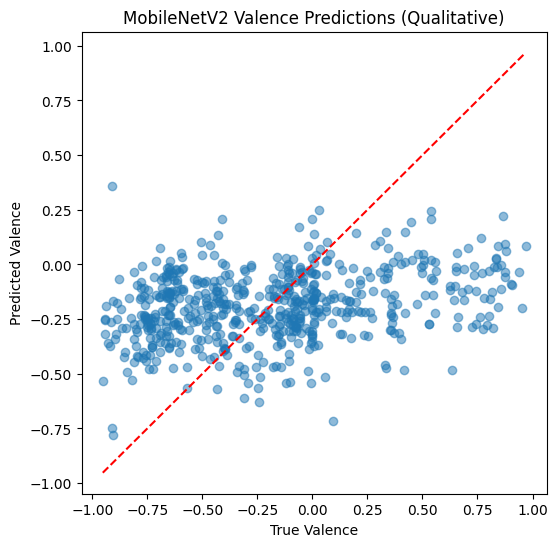

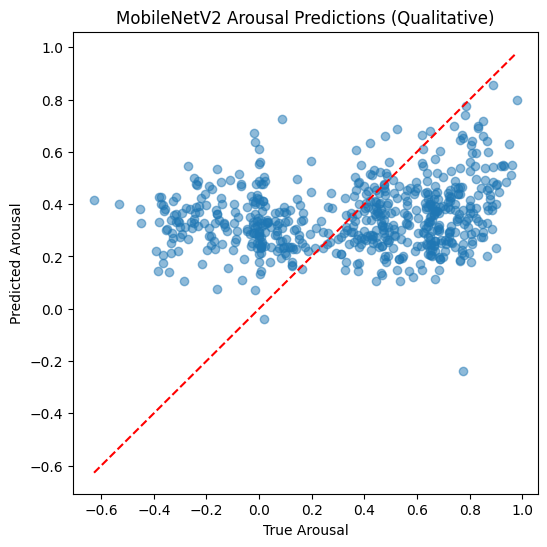

In [22]:
# True vs Predicted scatter for Valence (MobileNetV2)
plt.figure(figsize=(6,6))
plt.scatter(y_reg_test[:,0], y_reg_pred_mobilenet[:,0], alpha=0.5)
min_v = min(y_reg_test[:,0].min(), y_reg_pred_mobilenet[:,0].min())
max_v = max(y_reg_test[:,0].max(), y_reg_pred_mobilenet[:,0].max())
plt.plot([min_v, max_v], [min_v, max_v], 'r--')  # identity line
plt.xlabel("True Valence")
plt.ylabel("Predicted Valence")
plt.title("MobileNetV2 Valence Predictions (Qualitative)")
plt.show()

# True vs Predicted scatter for Arousal (MobileNetV2)
plt.figure(figsize=(6,6))
plt.scatter(y_reg_test[:,1], y_reg_pred_mobilenet[:,1], alpha=0.5)
min_a = min(y_reg_test[:,1].min(), y_reg_pred_mobilenet[:,1].min())
max_a = max(y_reg_test[:,1].max(), y_reg_pred_mobilenet[:,1].max())
plt.plot([min_a, max_a], [min_a, max_a], 'r--')  # identity line
plt.xlabel("True Arousal")
plt.ylabel("Predicted Arousal")
plt.title("MobileNetV2 Arousal Predictions (Qualitative)")
plt.show()


# **DenseNet**

In [23]:
def build_densenet_classification_model():
    base = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Freeze all but last 10 layers for fine-tuning
    for layer in base.layers[:-10]:
        layer.trainable = False

  # Add custom classification head
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(8, activation='softmax')(x)  # 8 emotion classes

  # Build and compile model
    model = Model(inputs=base.input, outputs=output)
    model.compile(optimizer=Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

densenet_class_model = build_densenet_classification_model()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
def build_densenet_regression_model():
    base = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Freeze all but last 10 layers
    for layer in base.layers[:-10]:
        layer.trainable = False

  # Add custom regression head
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(2, activation='linear')(x)  # 2 outputs: Valence, Arousal

   # Build and compile model
    model = Model(inputs=base.input, outputs=output)
    model.compile(optimizer=Adam(1e-4),
                  loss='mse',
                  metrics=['mae'])
    return model

densenet_reg_model = build_densenet_regression_model()

In [25]:
# train classification model
start = time.time()
densenet_class_history = densenet_class_model.fit(
    X_train, y_class_train,
    validation_data=(X_val, y_class_val),
    epochs=10,
    batch_size=16
)

training_times_class["DenseNet"] = time.time() - start


Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 66s 219ms/step - accuracy: 0.1410 - loss: 2.6442 - val_accuracy: 0.2083 - val_loss: 2.0328
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.1943 - loss: 2.0904 - val_accuracy: 0.2467 - val_loss: 1.9771
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.2270 - loss: 1.9988 - val_accuracy: 0.2883 - val_loss: 1.9216
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2697 - loss: 1.9122 - val_accuracy: 0.2667 - val_loss: 1.8921
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.3107 - loss: 1.8383 - val_accuracy: 0.2767 - val_loss: 1.8537
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.3281 - loss: 1.7831 - val_accuracy: 0.2883 - val_loss: 1.8145
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.3563 - loss: 1.7265 - val_accuracy: 0.3100 - val_loss: 1.7839
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.4011 - loss: 1.5768 - val_ac

In [26]:
# train regression model
start = time.time()

densenet_reg_history = densenet_reg_model.fit(
    X_train, y_reg_train,
    validation_data=(X_val, y_reg_val),
    epochs=10,
    batch_size=16
)
training_times_reg["DenseNet"] = time.time() - start


Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 58s 196ms/step - loss: 1.2717 - mae: 0.8856 - val_loss: 0.2721 - val_mae: 0.4154
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.3421 - mae: 0.4707 - val_loss: 0.2258 - val_mae: 0.3849
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.2477 - mae: 0.4034 - val_loss: 0.2128 - val_mae: 0.3767
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.2098 - mae: 0.3791 - val_loss: 0.2040 - val_mae: 0.3711
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1998 - mae: 0.3696 - val_loss: 0.1984 - val_mae: 0.3670
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.1843 - mae: 0.3545 - val_loss: 0.1940 - val_mae: 0.3613
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1836 - mae: 0.3534 - val_loss: 0.1915 - val_mae: 0.3588
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1777 - mae: 0.3470 - val_loss: 0.1888 - val_mae: 0.3601
Epoch 9/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 26m

# **Evaluation Metrics - DenseNet**

*Classification*

In [27]:
# Accuracy, F1, Cohen's Kappa

# predictions
y_class_pred_probs_densenet = densenet_class_model.predict(X_test)
y_class_pred_densenet = y_class_pred_probs_densenet.argmax(axis=1)  # Convert softmax to class labels

# Convert true labels to integers if they're one-hot
if y_class_test.ndim > 1:
    y_class_true = y_class_test.argmax(axis=1)
else:
    y_class_true = y_class_test


# Compute metrics
densenet_accuracy = accuracy_score(y_class_true, y_class_pred_densenet)
densenet_f1 = f1_score(y_class_true, y_class_pred_densenet, average='weighted')
densenet_kappa = cohen_kappa_score(y_class_true, y_class_pred_densenet)

print(f"Accuracy: {densenet_accuracy:.4f}")
print(f"F1-Score: {densenet_f1:.4f}")
print(f"Cohen's Kappa: {densenet_kappa:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 766ms/step
Accuracy: 0.3383
F1-Score: 0.3319
Cohen's Kappa: 0.2438


In [28]:
# Krippendorff’s Alpha for DenseNet

# Convert true labels to integers if they're one-hot
if y_class_test.ndim > 1:
    y_class_true = y_class_test.argmax(axis=1)
else:
    y_class_true = y_class_test

densenet_alpha = krippendorff.alpha(reliability_data=[y_class_true, y_class_pred_densenet])
print(f"DenseNet121 Krippendorff’s Alpha: {densenet_alpha:.4f}")


DenseNet121 Krippendorff’s Alpha: 0.1687


In [29]:
#auc-roc and auc-pr

# One-hot encode true labels if needed
y_class_true_onehot = to_categorical(y_class_true, num_classes=8)

densenet_auc_roc = roc_auc_score(y_class_true_onehot, y_class_pred_probs_densenet, average='macro', multi_class='ovr')
densenet_auc_pr = average_precision_score(y_class_true_onehot, y_class_pred_probs_densenet, average='macro')

print(f"DenseNet121 AUC-ROC: {densenet_auc_roc:.4f}")
print(f"DenseNet121 AUC-PR: {densenet_auc_pr:.4f}")

DenseNet121 AUC-ROC: 0.7668
DenseNet121 AUC-PR: 0.3452


*Regression*

In [30]:

y_reg_pred_densenet = densenet_reg_model.predict(X_test)

# Split into valence and arousal
valence_pred_densenet = y_reg_pred_densenet[:, 0]
arousal_pred_densenet = y_reg_pred_densenet[:, 1]

#compute RMSE

densenet_rmse_valence = np.sqrt(mean_squared_error(valence_true, valence_pred_densenet))
densenet_rmse_arousal = np.sqrt(mean_squared_error(arousal_true, arousal_pred_densenet))

print(f"RMSE - Valence: {densenet_rmse_valence:.4f}")
print(f"RMSE - Arousal: {densenet_rmse_arousal:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 627ms/step
RMSE - Valence: 0.4545
RMSE - Arousal: 0.3751


In [31]:
#pearson correlation

densenet_corr_valence, _ = pearsonr(valence_true, valence_pred_densenet)
densenet_corr_arousal, _ = pearsonr(arousal_true, arousal_pred_densenet)

print(f"Correlation - Valence: {densenet_corr_valence:.4f}")
print(f"Correlation - Arousal: {densenet_corr_arousal:.4f}")

Correlation - Valence: 0.2345
Correlation - Arousal: 0.1845


In [32]:
#sagr

def sagr(y_true, y_pred):
    return np.mean(np.sign(y_true) == np.sign(y_pred))

densenet_sagr_valence = sagr(valence_true, valence_pred_densenet)
densenet_sagr_arousal = sagr(arousal_true, arousal_pred_densenet)

print(f"SAGR - Valence: {densenet_sagr_valence:.4f}")
print(f"SAGR - Arousal: {densenet_sagr_arousal:.4f}")


SAGR - Valence: 0.6817
SAGR - Arousal: 0.7667


In [33]:
#ccc

def ccc(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    covariance = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    return (2 * covariance) / (var_true + var_pred + (mean_true - mean_pred)**2)

densenet_ccc_valence = ccc(valence_true, valence_pred_densenet)
densenet_ccc_arousal = ccc(arousal_true, arousal_pred_densenet)

print(f"CCC - Valence: {densenet_ccc_valence:.4f}")
print(f"CCC - Arousal: {densenet_ccc_arousal:.4f}")


CCC - Valence: 0.1375
CCC - Arousal: 0.1237


**Arousal & Valence Comparisons**




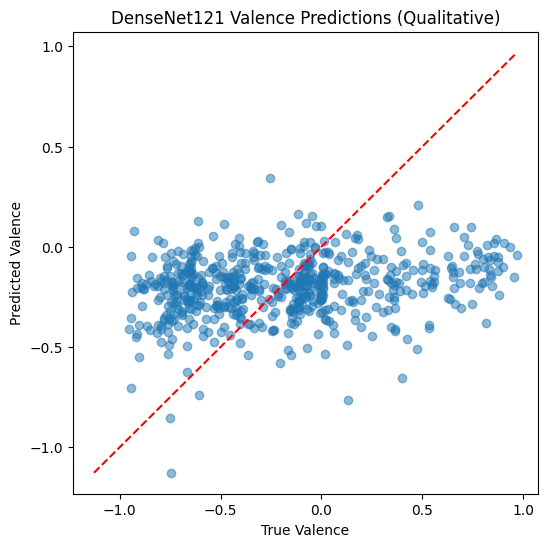

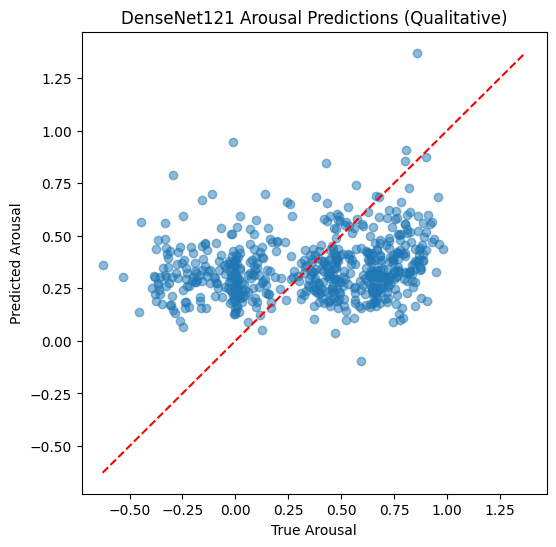

In [34]:
# True vs Predicted scatter for Valence (DenseNet121)
plt.figure(figsize=(6,6))
plt.scatter(y_reg_test[:,0], y_reg_pred_densenet[:,0], alpha=0.5)
min_v = min(y_reg_test[:,0].min(), y_reg_pred_densenet[:,0].min())
max_v = max(y_reg_test[:,0].max(), y_reg_pred_densenet[:,0].max())
plt.plot([min_v, max_v], [min_v, max_v], 'r--')  # identity line
plt.xlabel("True Valence")
plt.ylabel("Predicted Valence")
plt.title("DenseNet121 Valence Predictions (Qualitative)")
plt.show()

# True vs Predicted scatter for Arousal (DenseNet121)
plt.figure(figsize=(6,6))
plt.scatter(y_reg_test[:,1], y_reg_pred_densenet[:,1], alpha=0.5)
min_a = min(y_reg_test[:,1].min(), y_reg_pred_densenet[:,1].min())
max_a = max(y_reg_test[:,1].max(), y_reg_pred_densenet[:,1].max())
plt.plot([min_a, max_a], [min_a, max_a], 'r--')  # identity line
plt.xlabel("True Arousal")
plt.ylabel("Predicted Arousal")
plt.title("DenseNet121 Arousal Predictions (Qualitative)")
plt.show()


# **Qualitative Results**

***Classification Results***

In [35]:
#  Plot Correct vs Incorrect Predictions

def plot_classification_results(y_true, y_pred, X_data, model_name, max_examples=5):
    # Find correct and incorrect predictions
    correct_idx = np.where(y_pred == y_true)[0]
    incorrect_idx = np.where(y_pred != y_true)[0]

    # Randomly select samples
    selected_correct = np.random.choice(correct_idx, size=min(max_examples, len(correct_idx)), replace=False)
    selected_incorrect = np.random.choice(incorrect_idx, size=min(max_examples, len(incorrect_idx)), replace=False)
    selected = np.concatenate([selected_correct, selected_incorrect])

    # Plot results
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(selected):
        img = X_data[idx]
        true_label = y_true[idx]
        pred_label = y_pred[idx]

        # Rescale if normalized
        if img.max() <= 1.0:
            img_to_display = (img * 255).astype("uint8")
        else:
            img_to_display = img.astype("uint8")

        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(img_to_display)
        plt.axis("off")

        #green = correct, red = incorrect
        color = "green" if true_label == pred_label else "red"
        ax.set_title(f"T:{true_label} P:{pred_label}", color=color)

    plt.suptitle(f"{model_name} Qualitative Results: Correct (green) vs Incorrect (red)")
    plt.tight_layout()
    plt.show()


**MobileNet**

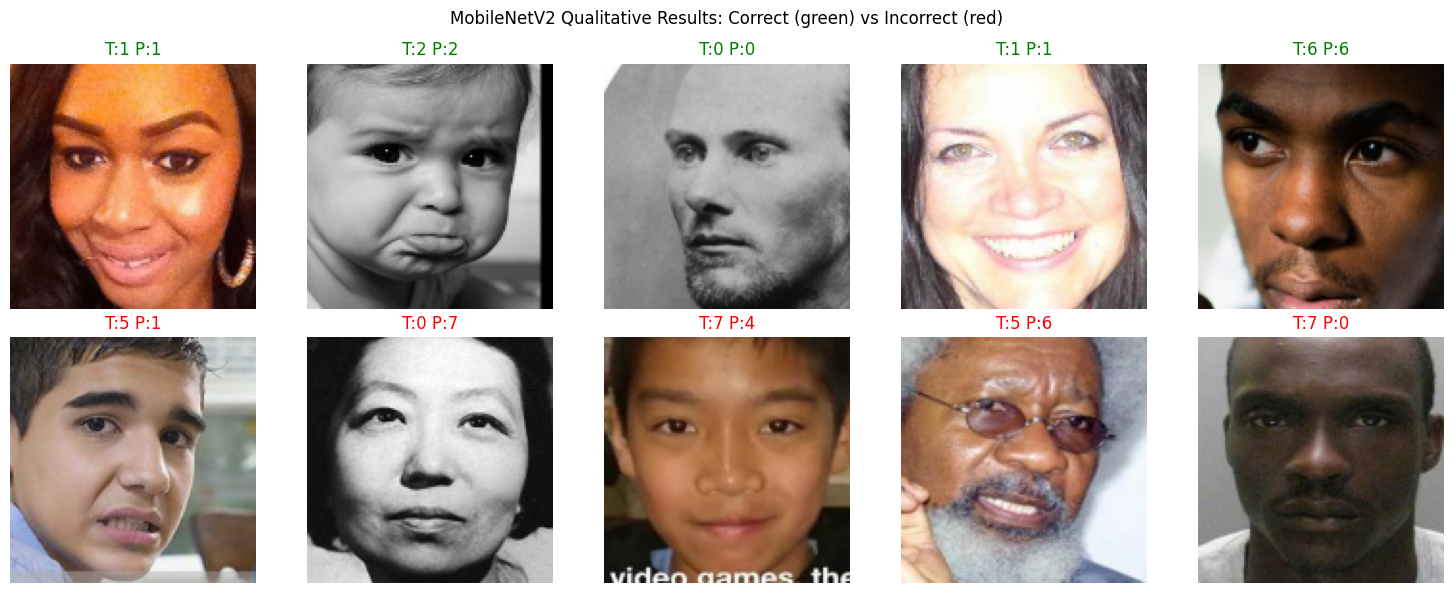

In [37]:
plot_classification_results(y_class_test, y_class_pred_mobilenet, X_test, "MobileNetV2")

**DenseNet**

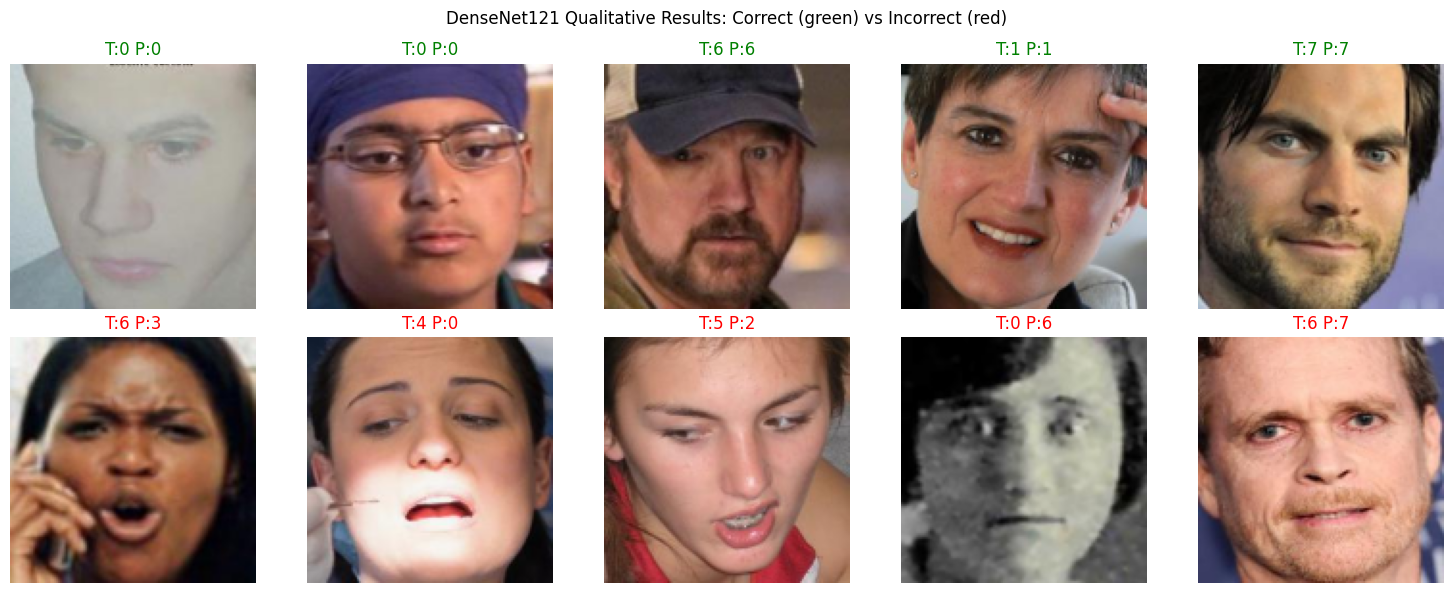

In [52]:
plot_classification_results(y_class_test, y_class_pred_densenet, X_test, "DenseNet121")

***Regression Results***

In [40]:

def plot_true_vs_pred(true_vals, pred_vals, target_name, model_name):
    plt.figure(figsize=(6,6))
    plt.scatter(true_vals, pred_vals, alpha=0.5)

    # Identity line for reference
    min_val = min(true_vals.min(), pred_vals.min())
    max_val = max(true_vals.max(), pred_vals.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.xlabel(f"True {target_name}")
    plt.ylabel(f"Predicted {target_name}")
    plt.title(f"{model_name} {target_name} Predictions (Qualitative)")
    plt.show()


def evaluate_regression_model(model, X_test, y_test, model_name):
    # Predict using the model
    y_pred = model.predict(X_test)

    # Plot Valence
    plot_true_vs_pred(y_test[:,0], y_pred[:,0], target_name="Valence", model_name=model_name)

    # Plot Arousal
    plot_true_vs_pred(y_test[:,1], y_pred[:,1], target_name="Arousal", model_name=model_name)


**MobileNet**

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


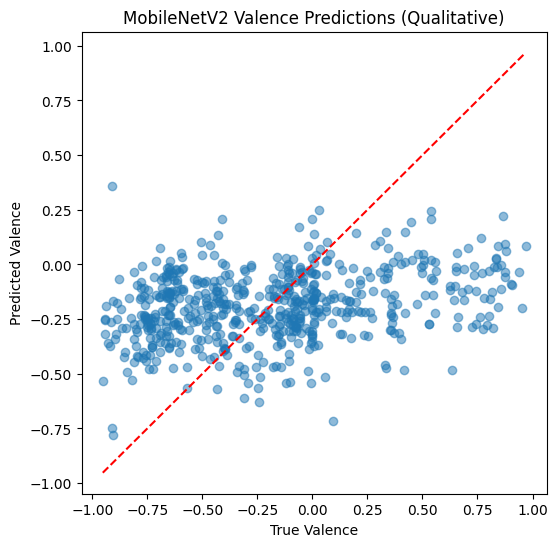

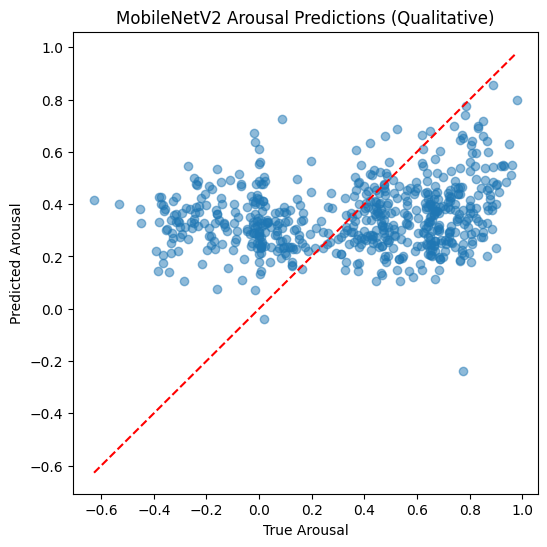

In [41]:
evaluate_regression_model(regression_model, X_test, y_reg_test, model_name="MobileNetV2")

**DenseNet**

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


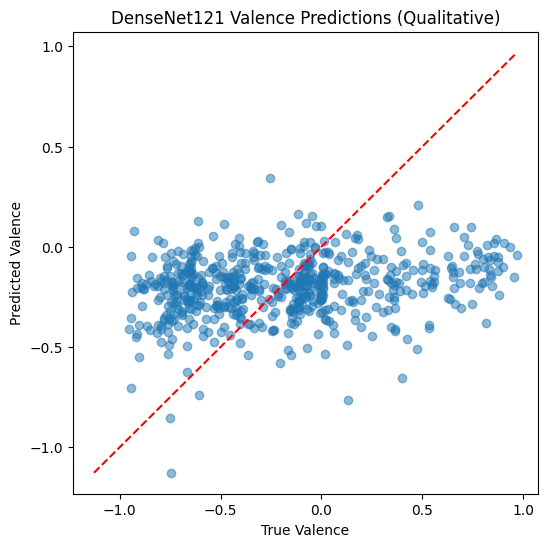

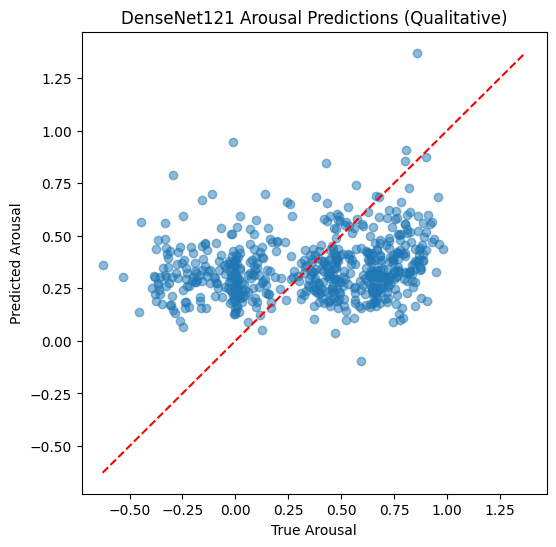

In [42]:
evaluate_regression_model(densenet_reg_model, X_test, y_reg_test, model_name="DenseNet121")

# **Classification Curves**

In [43]:
def plot_classification_training(history, model_name="Model"):
    # Loss
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


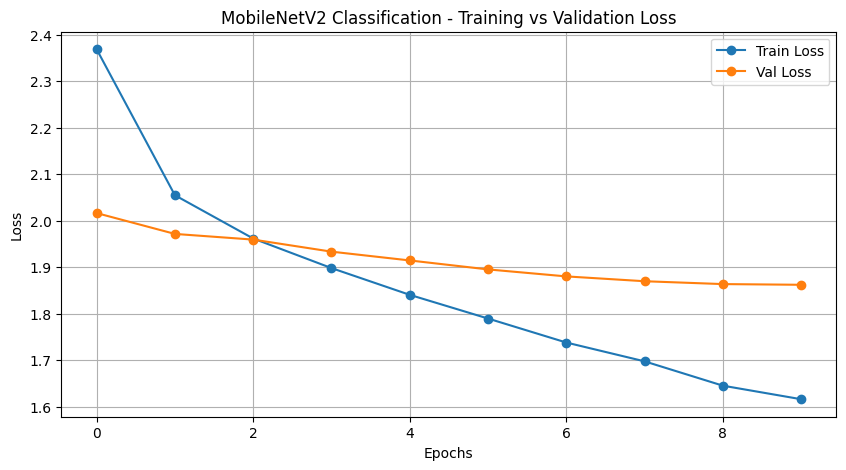

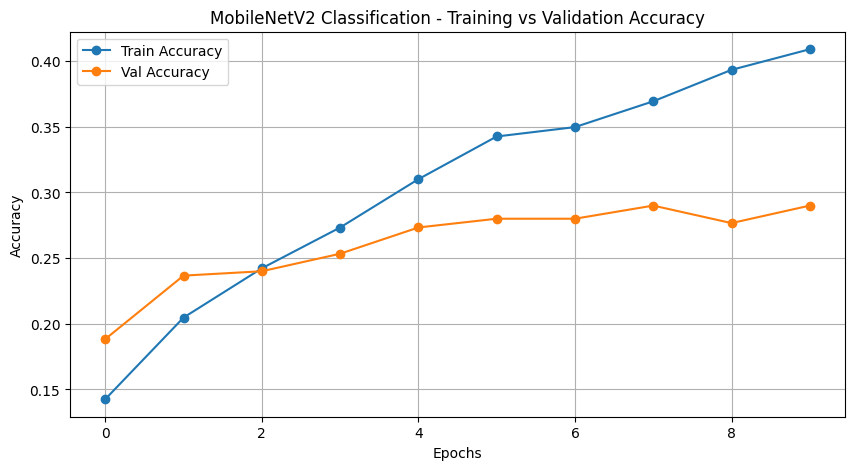

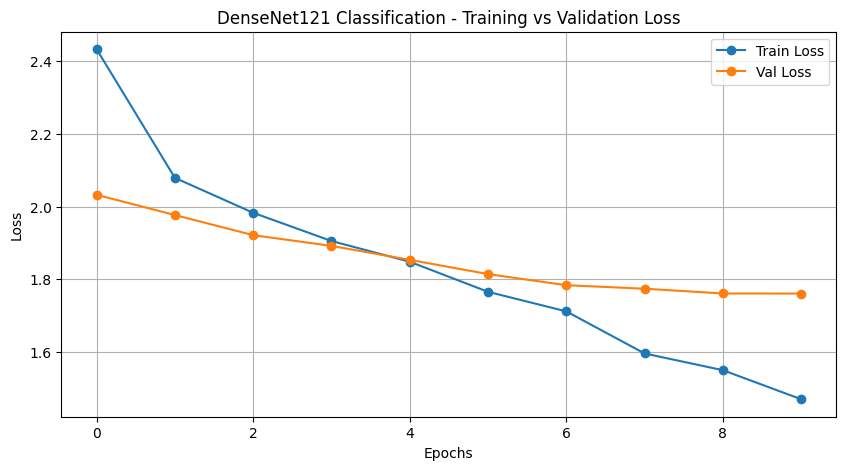

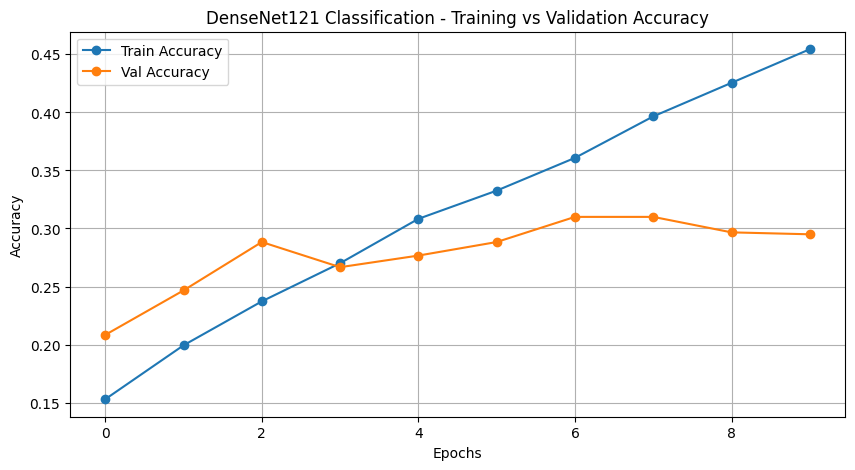

In [44]:
plot_classification_training(mobilenet_classification_history, model_name="MobileNetV2 Classification")
plot_classification_training(densenet_class_history, model_name="DenseNet121 Classification")


# **Regression Curves**

In [45]:
def plot_regression_training(history, model_name="Model"):
    # Loss (MSE)
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='Train Loss (MSE)', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss (MSE)', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title(f'{model_name} - Training vs Validation Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Mean Absolute Error (MAE)
    if 'mae' in history.history:
        plt.figure(figsize=(10,5))
        plt.plot(history.history['mae'], label='Train MAE', marker='o')
        plt.plot(history.history['val_mae'], label='Val MAE', marker='o')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.title(f'{model_name} - Training vs Validation MAE')
        plt.legend()
        plt.grid(True)
        plt.show()


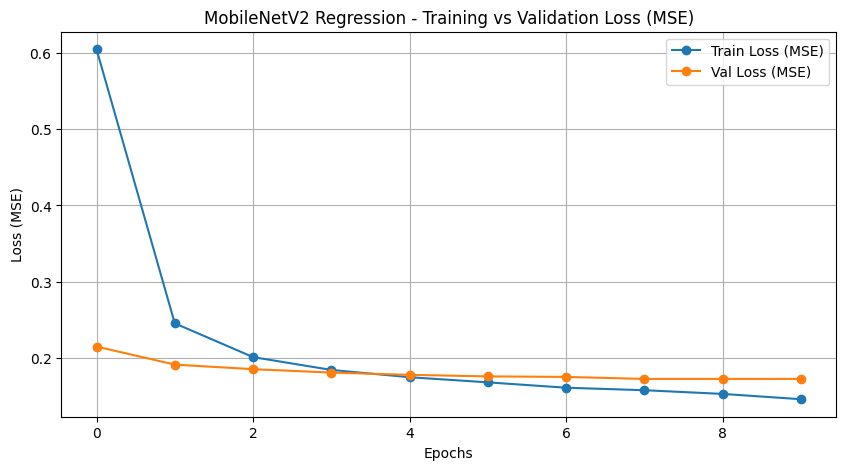

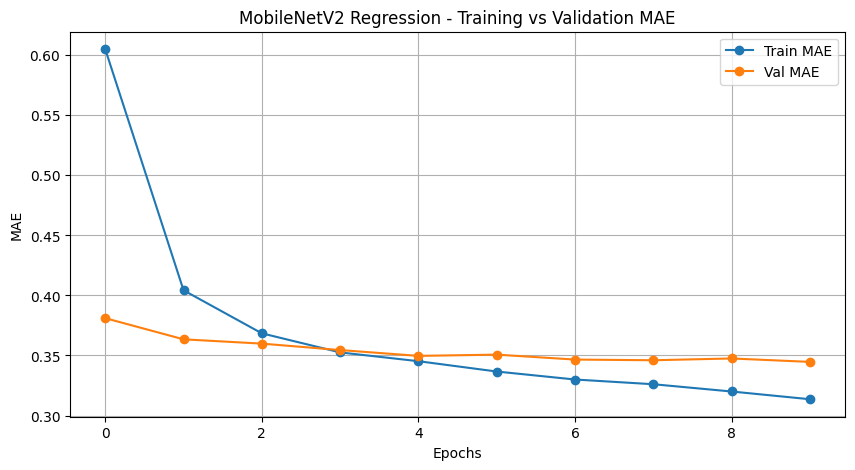

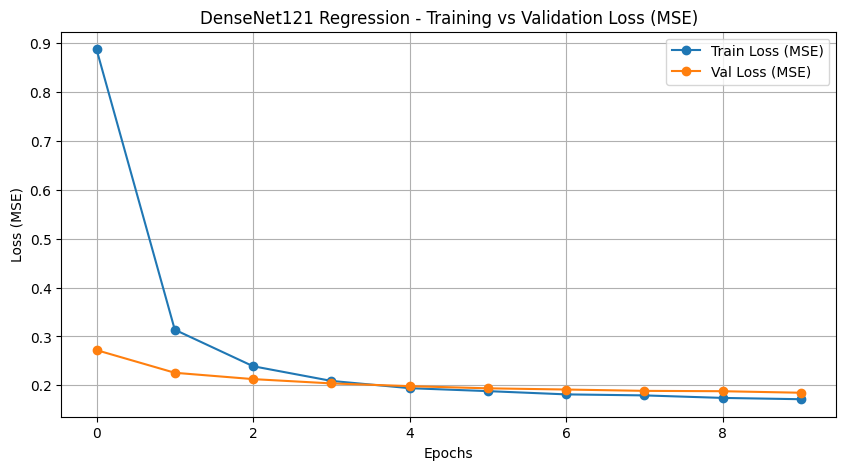

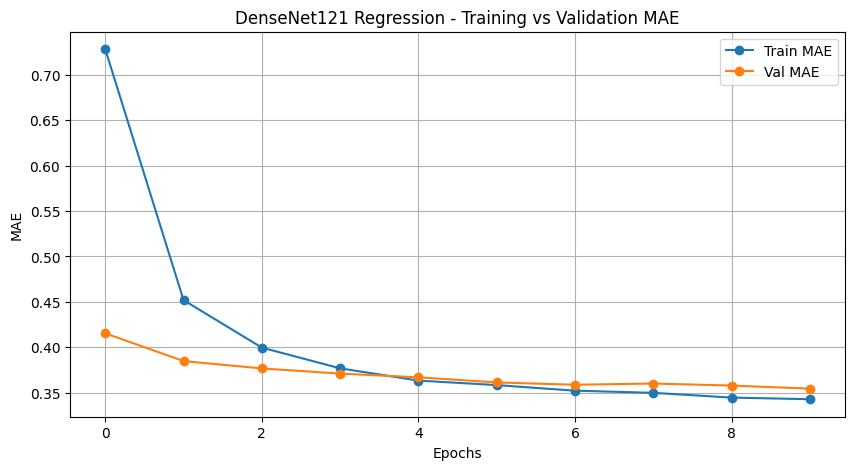

In [46]:
plot_regression_training(mobilenet_regression_history, model_name="MobileNetV2 Regression")
plot_regression_training(densenet_reg_history, model_name="DenseNet121 Regression")


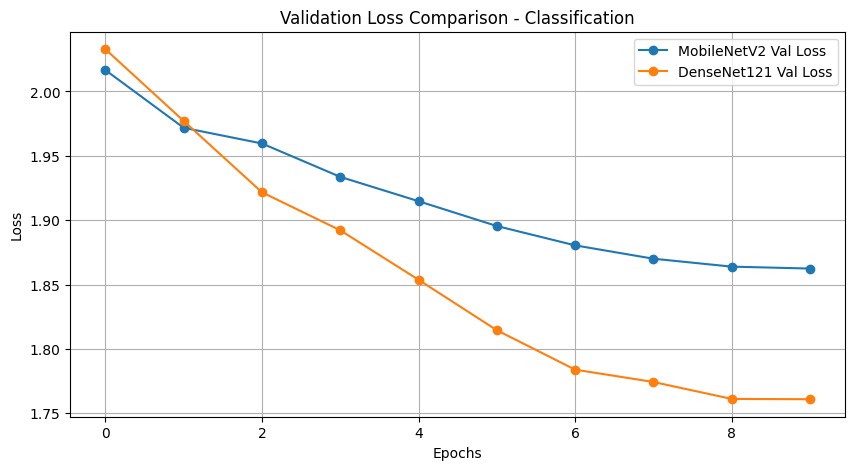

In [47]:
#combined view

#classification loss comaprison
plt.figure(figsize=(10,5))
plt.plot(mobilenet_classification_history.history['val_loss'], label='MobileNetV2 Val Loss', marker='o')
plt.plot(densenet_class_history.history['val_loss'], label='DenseNet121 Val Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison - Classification')
plt.legend()
plt.grid(True)
plt.show()


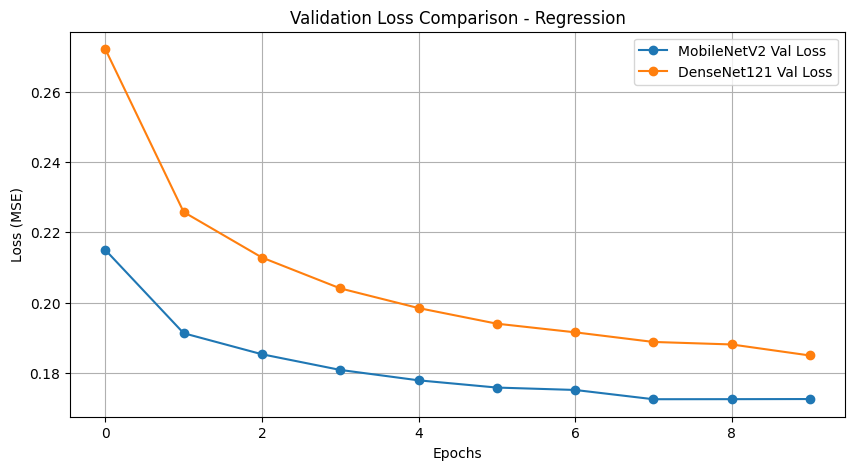

In [48]:
#combined view

#regression loss comparison
plt.figure(figsize=(10,5))
plt.plot(mobilenet_regression_history.history['val_loss'], label='MobileNetV2 Val Loss', marker='o')
plt.plot(densenet_reg_history.history['val_loss'], label='DenseNet121 Val Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Validation Loss Comparison - Regression')
plt.legend()
plt.grid(True)
plt.show()


# **Extra Credit**

In [49]:
#classification model

def build_custom_classification_model(input_shape=(128,128,3), num_classes=8):
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.25)(x)

    # Block 2
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.3)(x)

    # Block 3
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.4)(x)

    # Global Pooling + Dense Layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

custom_class_model = build_custom_classification_model()

In [50]:
#regression model

def build_custom_regression_model(input_shape=(128,128,3)):
    inputs = Input(shape=input_shape)

    # Same conv blocks as classification
    x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.4)(x)

    # Global Pooling
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output for Valence and Arousal
    outputs = Dense(2, activation='linear')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4),
                  loss='mse',
                  metrics=['mae'])
    return model

custom_reg_model = build_custom_regression_model()

In [51]:
#training-classification
start = time.time()

custom_class_history = custom_class_model.fit(
    X_train, y_class_train,
    validation_data=(X_val, y_class_val),
    epochs=10,
    batch_size=16
)

training_times_class["Custom CNN"] = time.time() - start


Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 32s 104ms/step - accuracy: 0.1268 - loss: 2.3240 - val_accuracy: 0.1250 - val_loss: 2.1691
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.1601 - loss: 2.1234 - val_accuracy: 0.1250 - val_loss: 2.2867
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.1422 - loss: 2.1056 - val_accuracy: 0.1233 - val_loss: 2.1163
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.1588 - loss: 2.0837 - val_accuracy: 0.1533 - val_loss: 2.0604
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.1791 - loss: 2.0488 - val_accuracy: 0.1467 - val_loss: 2.0688
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.1623 - loss: 2.0554 - val_accuracy: 0.1667 - val_loss: 2.0624
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.1620 - loss: 2.0456 - val_accuracy: 0.1517 - val_loss: 2.0823
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.1987 - loss: 2.0351 - val_ac

In [53]:
#training-regression
start = time.time()


custom_reg_history = custom_reg_model.fit(
    X_train, y_reg_train,
    validation_data=(X_val, y_reg_val),
    epochs=10,
    batch_size=16
)

training_times_reg["Custom CNN"] = time.time() - start


Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - loss: 0.7682 - mae: 0.6687 - val_loss: 0.2961 - val_mae: 0.4446
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.2676 - mae: 0.4136 - val_loss: 0.2678 - val_mae: 0.4219
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2144 - mae: 0.3819 - val_loss: 0.2131 - val_mae: 0.3803
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1962 - mae: 0.3684 - val_loss: 0.2017 - val_mae: 0.3734
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1963 - mae: 0.3692 - val_loss: 0.2001 - val_mae: 0.3707
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1958 - mae: 0.3689 - val_loss: 0.2000 - val_mae: 0.3705
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1921 - mae: 0.3655 - val_loss: 0.2001 - val_mae: 0.3738
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1932 - mae: 0.3662 - val_loss: 0.1934 - val_mae: 0.3645
Epoch 9/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms

In [54]:
# Classification Predictions
y_class_pred_probs_custom = custom_class_model.predict(X_test)
y_class_pred_custom = y_class_pred_probs_custom.argmax(axis=1)  # Convert softmax -> class labels

# If ground truth is one-hot, convert back to integers
if y_class_test.ndim > 1:
    y_class_true = y_class_test.argmax(axis=1)
else:
    y_class_true = y_class_test

# Regression Predictions
y_reg_pred_custom = custom_reg_model.predict(X_test)
valence_true = y_reg_test[:, 0]
arousal_true = y_reg_test[:, 1]
valence_pred = y_reg_pred_custom[:, 0]
arousal_pred = y_reg_pred_custom[:, 1]


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


**Evaluation Metrics - Classification**

In [55]:

#predictions for Custom CNN
y_class_pred_probs_custom = custom_class_model.predict(X_test)
y_class_pred_custom = y_class_pred_probs_custom.argmax(axis=1)  # Convert softmax -> class labels

# If ground truth is one-hot, convert back to integers
if y_class_test.ndim > 1:
    y_class_true = y_class_test.argmax(axis=1)
else:
    y_class_true = y_class_test

# Accuracy
custom_accuracy = accuracy_score(y_class_true, y_class_pred_custom)

# F1-score
custom_f1 = f1_score(y_class_true, y_class_pred_custom, average='weighted')

# Cohen's Kappa
custom_kappa = cohen_kappa_score(y_class_true, y_class_pred_custom)

# AUC-PR, AUC-ROC
custom_y_true_onehot = to_categorical(y_class_true, num_classes=8)
custom_auc_roc = roc_auc_score(custom_y_true_onehot, y_class_pred_probs_custom, average='macro', multi_class='ovr')
custom_auc_pr = average_precision_score(custom_y_true_onehot, y_class_pred_probs_custom, average='macro')

# Krippendorff's Alpha
custom_alpha = krippendorff.alpha(reliability_data=[y_class_true, y_class_pred_custom])

print("\n--- Custom CNN Classification Metrics ---")
print(f"Accuracy: {custom_accuracy:.4f}")
print(f"F1-Score: {custom_f1:.4f}")
print(f"Cohen's Kappa: {custom_kappa:.4f}")
print(f"Krippendorff's Alpha: {custom_alpha:.4f}")
print(f"AUC-ROC: {custom_auc_roc:.4f}")
print(f"AUC-PR: {custom_auc_pr:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

--- Custom CNN Classification Metrics ---
Accuracy: 0.1550
F1-Score: 0.1363
Cohen's Kappa: 0.0343
Krippendorff's Alpha: -0.0206
AUC-ROC: 0.5717
AUC-PR: 0.1685


**Evaluation Metrics - Regression**

In [56]:

# RMSE
custom_rmse_valence = np.sqrt(mean_squared_error(valence_true, valence_pred))
custom_rmse_arousal = np.sqrt(mean_squared_error(arousal_true, arousal_pred))

#Correlation (Pearson)
custom_corr_valence, _ = pearsonr(valence_true, valence_pred)
custom_corr_arousal, _ = pearsonr(arousal_true, arousal_pred)

# SAGR
def sagr(y_true, y_pred):
    return np.mean(np.sign(y_true) == np.sign(y_pred))

custom_sagr_valence = sagr(valence_true, valence_pred)
custom_sagr_arousal = sagr(arousal_true, arousal_pred)

# CCC
def ccc(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    covariance = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    return (2 * covariance) / (var_true + var_pred + (mean_true - mean_pred)**2)

custom_ccc_valence = ccc(valence_true, valence_pred)
custom_ccc_arousal = ccc(arousal_true, arousal_pred)

print("\n--- Custom CNN Regression Metrics ---")
print(f"RMSE - Valence: {custom_rmse_valence:.4f}, Arousal: {custom_rmse_arousal:.4f}")
print(f"Correlation - Valence: {custom_corr_valence:.4f}, Arousal: {custom_corr_arousal:.4f}")
print(f"SAGR - Valence: {custom_sagr_valence:.4f}, Arousal: {custom_sagr_arousal:.4f}")
print(f"CCC - Valence: {custom_ccc_valence:.4f}, Arousal: {custom_ccc_arousal:.4f}")



--- Custom CNN Regression Metrics ---
RMSE - Valence: 0.4821, Arousal: 0.3920
Correlation - Valence: 0.0136, Arousal: -0.0516
SAGR - Valence: 0.6467, Arousal: 0.7683
CCC - Valence: 0.0071, Arousal: -0.0253


# **Comparison (MobileNet, DenseNet, Custom CNN)**

In [59]:
def classification_metrics(y_true, y_pred, y_proba=None):
    if y_true.ndim > 1:
        y_true = y_true.argmax(axis=1)
    if y_pred.ndim > 1:
        y_pred = y_pred.argmax(axis=1)

    results = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred, average="weighted"),
        "Cohen's Kappa": cohen_kappa_score(y_true, y_pred),
    }
    if y_proba is not None:
        # One-hot encode true labels for AUC calculation
        y_true_onehot = to_categorical(y_true, num_classes=8)
        results["AUC (ROC)"] = roc_auc_score(y_true_onehot, y_proba, multi_class="ovr")
        results["AUC (PR)"] = average_precision_score(y_true_onehot, y_proba, average="macro")
    else:
        results["AUC (ROC)"] = np.nan
        results["AUC (PR)"] = np.nan

    return results


def concordance_cc(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    covariance = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    return (2 * covariance) / (var_true + var_pred + (mean_true - mean_pred)**2)


def regression_metrics(y_true, y_pred):
    # RMSE
    rmse_val = np.sqrt(mean_squared_error(y_true[:,0], y_pred[:,0]))
    rmse_aro = np.sqrt(mean_squared_error(y_true[:,1], y_pred[:,1]))

    # Correlation
    corr_val, _ = pearsonr(y_true[:,0], y_pred[:,0])
    corr_aro, _ = pearsonr(y_true[:,1], y_pred[:,1])

    # SAGR
    sagr_val = np.mean(np.sign(y_true[:,0]) == np.sign(y_pred[:,0]))
    sagr_aro = np.mean(np.sign(y_true[:,1]) == np.sign(y_pred[:,1]))

    # CCC
    ccc_val = concordance_cc(y_true[:,0], y_pred[:,0])
    ccc_aro = concordance_cc(y_true[:,1], y_pred[:,1])

    results = {
        "RMSE (Valence)": rmse_val,
        "RMSE (Arousal)": rmse_aro,
        "CORR (Valence)": corr_val,
        "CORR (Arousal)": corr_aro,
        "SAGR (Valence)": sagr_val,
        "SAGR (Arousal)": sagr_aro,
        "CCC (Valence)": ccc_val,
        "CCC (Arousal)": ccc_aro,
    }
    return results



# models comaprison
results_class = {}
results_reg = {}

# predictions list
y_class_pred_probs_mobilenet = classification_model.predict(X_test)
y_class_pred_mobilenet = y_class_pred_probs_mobilenet.argmax(axis=1)
y_reg_pred_mobilenet = regression_model.predict(X_test)

y_class_pred_probs_densenet = densenet_class_model.predict(X_test)
y_class_pred_densenet = y_class_pred_probs_densenet.argmax(axis=1)
y_reg_pred_densenet = densenet_reg_model.predict(X_test)

y_class_pred_probs_custom = custom_class_model.predict(X_test)
y_class_pred_custom = y_class_pred_probs_custom.argmax(axis=1)
y_reg_pred_custom = custom_reg_model.predict(X_test)

# y_class_test is in the correct format
if y_class_test.ndim > 1:
    y_class_true = y_class_test.argmax(axis=1)
else:
    y_class_true = y_class_test

y_reg_true = y_reg_test

models = {
    "MobileNet": (y_class_true, y_class_pred_mobilenet, y_class_pred_probs_mobilenet, y_reg_true, y_reg_pred_mobilenet),
    "DenseNet": (y_class_true, y_class_pred_densenet, y_class_pred_probs_densenet, y_reg_true, y_reg_pred_densenet),
    "Custom CNN": (y_class_true, y_class_pred_custom, y_class_pred_probs_custom, y_reg_true, y_reg_pred_custom),
}

for model_name, (y_c_true, y_c_pred, y_c_proba, y_r_true, y_r_pred) in models.items():
    results_class[model_name] = classification_metrics(y_c_true, y_c_pred, y_c_proba)
    results_reg[model_name] = regression_metrics(y_r_true, y_r_pred)

df_class = pd.DataFrame(results_class).T
df_reg = pd.DataFrame(results_reg).T

print("\nClassification Metrics ")
display(df_class)

print("\nRegression Metrics")
display(df_reg)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Classification Metrics 


,Accuracy,F1-Score,Cohen's Kappa,AUC (ROC),AUC (PR)
MobileNet,0.295000,0.284377,0.194286,0.707575,0.284489
DenseNet,0.338333,0.331868,0.243810,0.766829,0.345196
Custom CNN,0.155000,0.136317,0.034286,0.571657,0.168540



Regression Metrics


,RMSE (Valence),RMSE (Arousal),CORR (Valence),CORR (Arousal),SAGR (Valence),SAGR (Arousal),CCC (Valence),CCC (Arousal)
MobileNet,0.443455,0.369550,0.306145,0.204772,0.718333,0.765000,0.187579,0.125273
DenseNet,0.454506,0.375126,0.234541,0.184539,0.681667,0.766667,0.137473,0.123704
Custom CNN,0.482136,0.392019,0.013585,-0.051618,0.646667,0.768333,0.007123,-0.025344


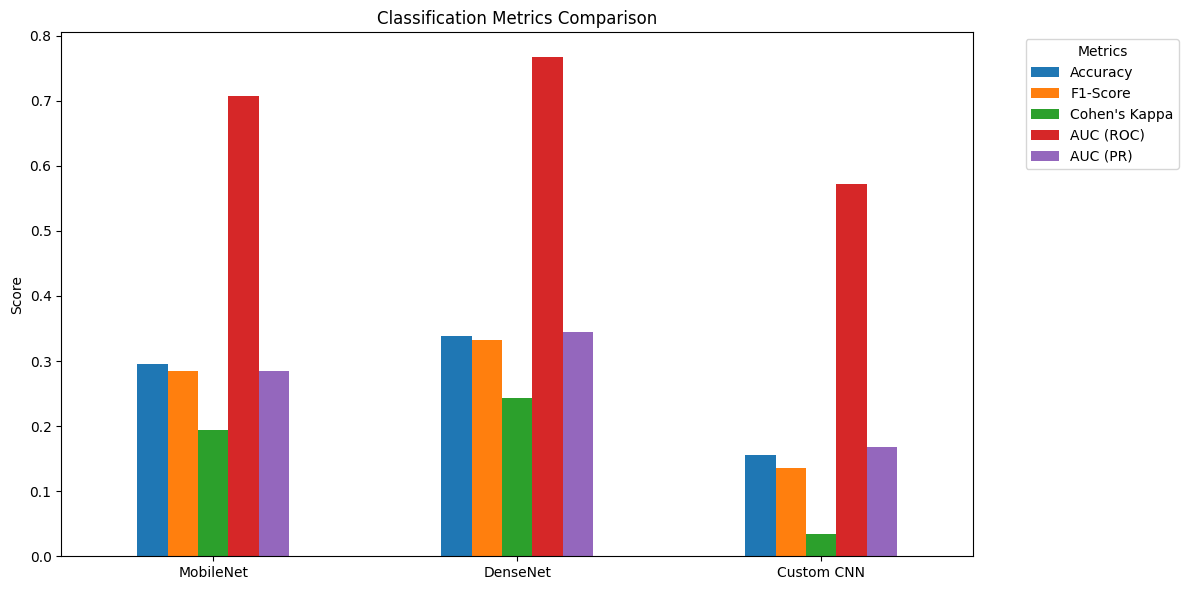

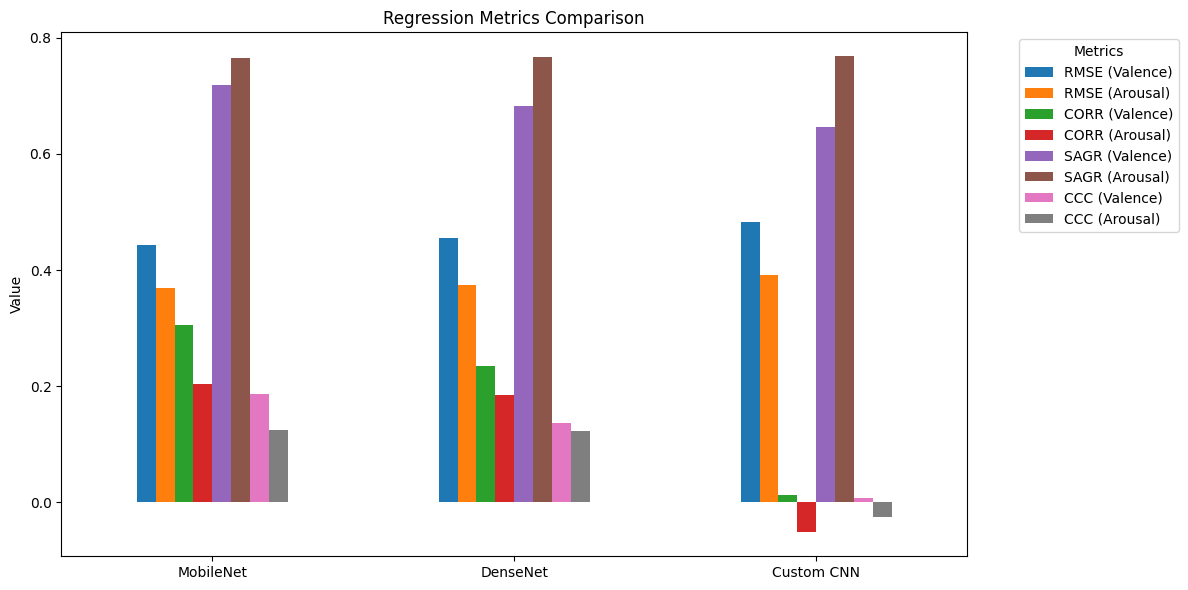

In [60]:

#  Classification Bar Plot
df_class.plot(kind="bar", figsize=(12,6))
plt.title("Classification Metrics Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Regression Bar Plot
df_reg.plot(kind="bar", figsize=(12,6))
plt.title("Regression Metrics Comparison")
plt.ylabel("Value")
plt.xticks(rotation=0)
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


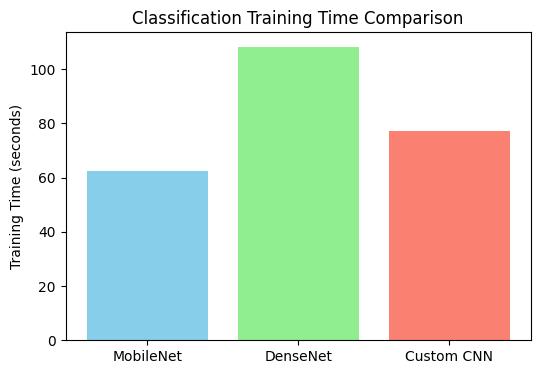

In [61]:
#Training Time comparison - classification

plt.figure(figsize=(6,4))
plt.bar(training_times_class.keys(), training_times_class.values(), color=["skyblue","lightgreen","salmon"])
plt.ylabel("Training Time (seconds)")
plt.title("Classification Training Time Comparison")
plt.show()


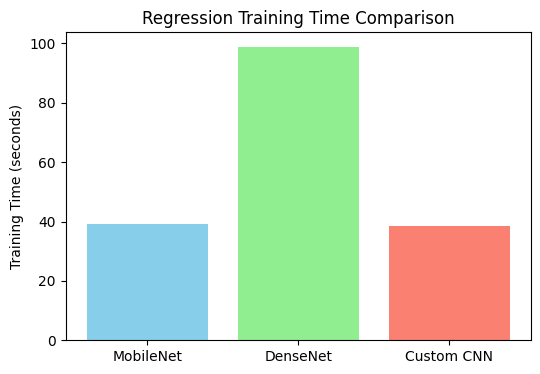

In [62]:
#Training Time comparison - regression

plt.figure(figsize=(6,4))
plt.bar(training_times_reg.keys(), training_times_reg.values(), color=["skyblue","lightgreen","salmon"])
plt.ylabel("Training Time (seconds)")
plt.title("Regression Training Time Comparison")
plt.show()
